In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Concatenate,Layer,Lambda,Input,Multiply,SimpleRNN,GRU,ReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers

Using TensorFlow backend.


In [2]:
Loc = np.asarray(np.linspace(0,47,48)) 

In [3]:
def create_dataset(ns, fname, look_back=1):
    dataX, dataY = [], []
    for c in ns:
        dataframe = pandas.read_csv(fname, usecols=[int(c)], engine='python')
        dataframe.dropna(how='all',inplace=True)
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        for i in range(len(dataset)-look_back):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_dataset3(ns, fname, totalPop, ps, look_back=1):
    dataX, dataY, mD = [], [], []
    for c in ns:
        pop = totalPop[int(c)]
        dataframe = pandas.read_csv(fname, usecols=[int(c)], engine='python')
        dataframe.dropna(how='all',inplace=True)
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        dataset /= pop
        dataset = np.power(dataset,(1./ps))
        for i in range(len(dataset)-look_back):
            a = dataset[i:(i+look_back), 0]
            b = dataset[i + look_back, 0]
            #maxA = np.max(a)
            #if maxA > 0:
            #    a /= maxA
            #    b /= maxA
            
            meanA = np.mean(a)
            #stdA = np.std(a)
            
            if meanA > 0:
                a /= meanA
                b /= meanA
            
            #a -= meanA
            #b -= meanA
            #if stdA > 0:
            #    a /= stdA
            #    b /= stdA
            
            dataX.append(a)
            mD.append(meanA)
            #sD.append(stdA)
            dataY.append(b)
    return np.array(dataX), np.array(dataY), np.array(mD)

In [4]:

dataframePop = pandas.read_csv('TotalPop.csv', engine='python')
datasetPop = dataframePop.values
datasetPop = datasetPop.astype('float32')
totalPop = datasetPop[0,:]

lb = 7
ps = 1

trainActive, targetActive, activeM = create_dataset3(Loc,'Active_cases_data.csv',totalPop,ps,lb)

trainTotal, targetTotal, totalM = create_dataset3(Loc,'Total_cases_data.csv',totalPop,ps,lb)

train1d, target1d, one_dayM = create_dataset3(Loc,'One-day-change_data.csv',totalPop,ps,lb)

train2d, target2d, three_dayM = create_dataset3(Loc,'Three-day-change_data.csv',totalPop,ps,lb)

train3d, target3d, seven_dayM = create_dataset3(Loc,'Seven-day-change_data.csv',totalPop,ps,lb)

trainPop, targetPop = create_dataset(Loc,'Pop_data.csv',lb)
maxPop = np.max(targetPop)
minPop = np.min(trainPop)
trainPop = (trainPop - minPop)/(maxPop - minPop)
targetPop = (targetPop - minPop)/(maxPop - minPop)

trainMed, targetMed = create_dataset(Loc,'Med_data.csv',lb)
maxMed = np.max(targetMed)
minMed = np.min(trainMed)
trainMed = (trainMed - minMed)/(maxMed - minMed)
targetMed = (targetMed - minMed)/(maxMed - minMed)

In [5]:
sql = trainActive.shape[0]
trainX = np.concatenate((np.reshape(trainActive,(sql,lb,1)),np.reshape(trainTotal,(sql,lb,1)),np.reshape(train1d,(sql,lb,1)),np.reshape(train2d,(sql,lb,1)),np.reshape(train3d,(sql,lb,1)),np.reshape(trainPop,(sql,lb,1)),np.reshape(trainMed,(sql,lb,1))),axis=2)
#trainX = np.concatenate((np.reshape(trainActive,(sql,lb,1)),np.reshape(trainTotal,(sql,lb,1)),np.reshape(trainPop,(sql,lb,1)),np.reshape(trainMed,(sql,lb,1))),axis=2)

trainY = np.concatenate((np.reshape(targetActive,(sql,1)),np.reshape(targetTotal,(sql,1))),axis=1)

In [6]:
numR = 1
fcl = 90

totalPredict = np.zeros((1,fcl))
activePredict = np.zeros((1,fcl))

for m_run in range(numR):
    print(m_run)
    # create and fit the LSTM network
    numF = 2
    numF2 = 7

    AllInput = Input(shape=(lb,numF2))
    RecInput = Lambda(lambda AllInput:AllInput[:,:,:numF],name='RecIn')(AllInput)
    HidInput = Lambda(lambda AllInput:AllInput[:,-1,numF:],name='HIn')(AllInput)
    H = LSTM(20, input_shape=(lb,numF))(RecInput)
    D2 = Dense(20,activation='sigmoid')(HidInput)
    Data = Concatenate()([H,D2])
    out = Dense(2,activation='relu')(Data)
    
    #H = LSTM(20, input_shape=(lb,numF))(RecInput)
    #D2 = Dense(20,activation='sigmoid')(HidInput)
    #Data = Concatenate()([H,D2])
    #D3 = Dense(20,activation='sigmoid')(Data)
    #out1 = Dense(2)(D3)
    #out = ReLU(max_value = 2)(out1

    CoVid = Model(AllInput,out)
    #CoVid.summary()
    ADopt = optimizers.Adam(lr=0.0001)
    CoVid.compile(loss='mean_squared_error', optimizer=ADopt)
    CoVid.fit(trainX, trainY, epochs=100, batch_size=50, verbose=1)

    BexarPop = 1975000
    testPop =  1553
    testMed =  (7839./BexarPop)*10000

    testPop = (testPop - minPop)/(maxPop - minPop)

    testMed = (testMed - minMed)/(maxMed - minMed)
    
    testActive = np.power(np.asarray([29,29,39,45,56,68,81])/BexarPop,(1./ps))
    testTotal = np.power(np.asarray([29,29,39,45,57,69,84])/BexarPop,(1./ps))
    test1d = np.power(np.asarray([4,0,10,6,12,12,15])/BexarPop,(1./ps))
    test2d = np.power(np.asarray([29,29,14,16,28,30,39])/BexarPop,(1./ps))
    test3d = np.power(np.asarray([29,29,39,45,57,69,84])/BexarPop,(1./ps))
    
    #maxA = np.max(testActive)
    #maxT = np.max(testTotal)
    #max1d = np.max(test1d)
    #max2d = np.max(test2d)
    #max3d = np.max(test3d)
    
    #testActive /= maxA
    #testTotal /= maxT
    #test1d /= max1d
    #test2d /= max2d
    #test3d /= max3d
    
    meanA = np.mean(testActive)
    meanT = np.mean(testTotal)
    mean1d = np.mean(test1d)
    mean2d = np.mean(test2d)
    mean3d = np.mean(test3d)
    
    testActive /= meanA
    testTotal /= meanT
    test1d /= mean1d
    test2d /= mean2d
    test3d /= mean3d
    
    #stdA = np.std(testActive)
    #stdT = np.std(testTotal)
    #std1d = np.std(test1d)
    #std2d = np.std(test2d)
    #std3d = np.std(test3d)
    
    #testActive -= meanA
    #testTotal -= meanT
    #test1d -= mean1d
    #test2d -= mean2d
    #test3d -= mean3d
    
    #testActive /= stdA
    #testTotal /= stdT
    #test1d /= std1d
    #test2d /= std2d
    #test3d /= std3d
    

    f1 = np.reshape(testActive,(1,lb,1))
    f2 = np.reshape(testTotal,(1,lb,1))
    f3 = np.reshape(test1d,(1,lb,1))
    f4 = np.reshape(test2d,(1,lb,1))
    f5 = np.reshape(test3d,(1,lb,1))
    f6 = np.reshape([testPop,testPop,testPop,testPop,testPop,testPop,testPop],(1,lb,1))
    f7 = np.reshape([testMed,testMed,testMed,testMed,testMed,testMed,testMed],(1,lb,1))

    totalPredictT = np.zeros((1,fcl))
    activePredictT = np.zeros((1,fcl))
    
    totalGT = np.asarray([25,29,29,39,45,57,69,84])
    activeGT = np.asarray([25,29,29,39,45,56,68,81])
    
    initX = np.concatenate((f1,f2,f3,f4,f5,f6,f7),axis=2)
    for tp in range(fcl):
        prevX = initX
        oi = prevX[0,1:,:]
        singlePredict = CoVid.predict(initX)
        
        prevT7 = prevX[0,0,1]
        
        prevT3 = prevX[0,4,1]
        
        prevT1 = prevX[0,-1,1]
        
        currentT = np.float32(singlePredict[0][1])
        
        f3 = currentT - prevT1
        f4 = currentT - prevT3
        f5 = currentT - prevT7
        
        ci = np.reshape(prevX[0,-1,5:],(1,2))
        di = np.reshape(np.asarray([f3,f4,f5]),(1,3))
        completeIn = np.concatenate((singlePredict,di,ci),axis=1)
        initXt = np.concatenate((oi,completeIn),axis=0)
        initXt = np.reshape(initXt,(1,lb,numF2))
        
        totalPredictT[0,tp] = np.power((np.float32(singlePredict[0][1])*meanT),ps)
        activePredictT[0,tp] = np.power((np.float32(singlePredict[0][0])*meanA),ps)
        
        t1 = initXt[0,:,0]
        t1 *= meanA
        meanA = np.mean(t1)
        t1 /= meanA
        #t1 *= stdA
        #t1 += meanA
        #meanA = np.mean(t1)
        #stdA = np.std(t1)
        #t1 = (t1-meanA)/stdA
        #t1 *= maxA
        #maxA = np.max(t1)
        #t1 /= maxA
        t1 = np.reshape(t1,(lb,1))
        
        t2 = initXt[0,:,1]
        t2 *= meanT
        meanT = np.mean(t2)
        t2 /= meanT
        #t2*= stdT
        #t2 += meanT
        #meanT = np.mean(t2)
        #stdT = np.std(t2)
        #t2 = (t2-meanT)/stdT
        #t2 *= maxT
        #maxT = np.max(t2)
        #t2 /= maxT
        t2 = np.reshape(t2,(lb,1))
        
        t3 = initXt[0,:,2]
        t3 *= mean1d
        mean1d = np.mean(t3)
        t3 /= mean1d
        #t3 *= std1d
        #t3 += mean1d
        #mean1d = np.mean(t3)
        #std1d = np.std(t3)
        #t3 = (t3-mean1d)/std1d
        #t3 *= max1d
        #max1d = np.max(t3)
        #t3 /= max1d
        t3 = np.reshape(t3,(lb,1))
        
        t4 = initXt[0,:,3]
        t4 *= mean2d
        mean2d = np.mean(t4)
        t4 /= mean2d
        #t4 *= std2d
        #t4 += mean2d
        #mean2d = np.mean(t4)
        #std2d = np.std(t4)
        #t4 = (t4-mean2d)/std2d
        #t4 *= max2d
        #max2d = np.max(t4)
        #t4 /= max2d
        t4 = np.reshape(t4,(lb,1))
        
        t5 = initXt[0,:,4]
        t5 *= mean3d
        mean3d = np.mean(t5)
        t5 /= mean3d
        #t5*= std3d
        #t5 += mean3d
        #mean3d = np.mean(t5)
        #std3d = np.std(t5)
        #t5 = (t5-mean3d)/std3d
        #t5 *= max3d
        #max3d = np.max(t5)
        #t5 /= max3d
        t5 = np.reshape(t5,(lb,1))
        
        t6 = initXt[0,:,5]
        t6 = np.reshape(t6,(lb,1))
        
        t7 = initXt[0,:,6]
        t7 = np.reshape(t7,(lb,1))
        
        initX = np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=1)
        initX = np.reshape(initX,(1,lb,numF2))
        
    totalPredict = totalPredict + totalPredictT/numR
    activePredict = activePredict + activePredictT/numR
    

0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2736/2736 [==============================] - 4s 1ms/step - loss: 2.1258
Epoch 2/100
2736/2736 [==============================] - 1s 373us/step - loss: 1.9097
Epoch 3/100
2736/2736 [==============================] - 1s 375us/step - loss: 1.7640
Epoch 4/100
2736/2736 [==============================] - 1s 369us/step - loss: 1.6643
Epoch 5/100
2736/2736 [==============================] - 1s 372us/step - loss: 1.5981
Epoch 6/100
2736/2736 [==============================] - 1s 378us/step - loss: 1.5561
Epoch 7/100
2736/2736 [==============================] - 1s 371us/step - loss: 1.5312
Epoch 8/100
2736/2736 [==============================] - 1s 376us/step - loss: 1.5170
Epoch 9/100
2736/2736 [==============================] - 1s 375us/step - loss: 1.5071
Epoch 10/100
2736/2736 [==============================] - 1s 374us/step - loss: 1.4994
Epoch 11/100
2736/2

2736/2736 [==============================] - 1s 372us/step - loss: 0.8146
Epoch 90/100
2736/2736 [==============================] - 1s 370us/step - loss: 0.8108
Epoch 91/100
2736/2736 [==============================] - 1s 375us/step - loss: 0.8064
Epoch 92/100
2736/2736 [==============================] - 1s 369us/step - loss: 0.8024
Epoch 93/100
2736/2736 [==============================] - 1s 371us/step - loss: 0.7982
Epoch 94/100
2736/2736 [==============================] - 1s 375us/step - loss: 0.7945
Epoch 95/100
2736/2736 [==============================] - 1s 373us/step - loss: 0.7912
Epoch 96/100
2736/2736 [==============================] - 1s 372us/step - loss: 0.7872
Epoch 97/100
2736/2736 [==============================] - 1s 379us/step - loss: 0.7834
Epoch 98/100
2736/2736 [==============================] - 1s 376us/step - loss: 0.7802
Epoch 99/100
2736/2736 [==============================] - 1s 373us/step - loss: 0.7767
Epoch 100/100
2736/2736 [==============================]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide


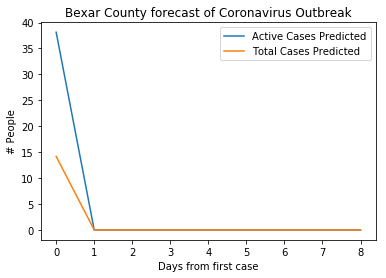

In [7]:
plt.plot((activePredict[0,:])*BexarPop)
plt.plot((totalPredict[0,:])*BexarPop)
plt.xlabel('Days from first case')
plt.ylabel('# People')
plt.title('Bexar County forecast of Coronavirus Outbreak')
plt.legend(['Active Cases Predicted','Total Cases Predicted'])
plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


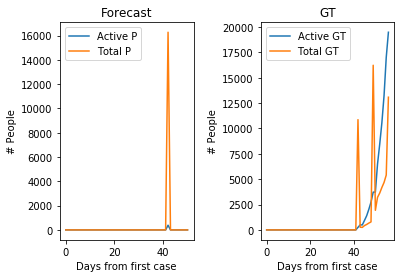

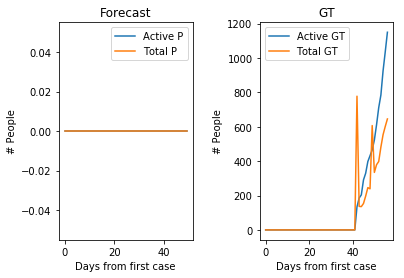

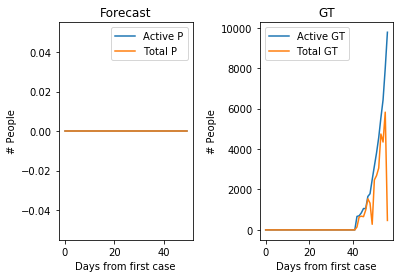

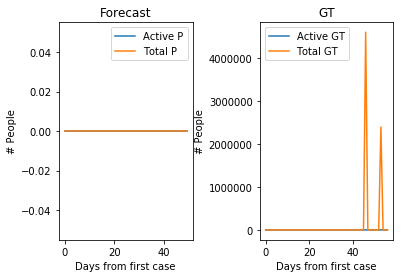

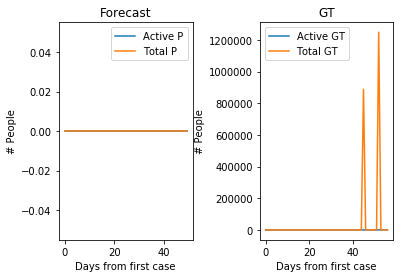

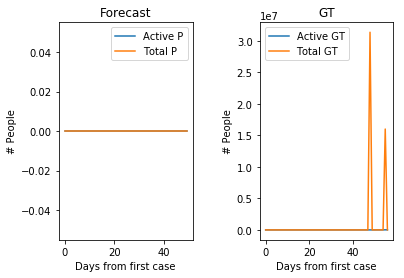

In [8]:
Loc2 = np.asarray([48,49,50,51,52,53]) 

for st in range(6):
    
    testActive, targetActiveT, activeM = create_dataset3([Loc2[st]],'Active_cases_data.csv',totalPop,ps,lb)

    testTotal, targetTotalT, totalLM = create_dataset3([Loc2[st]],'Total_cases_data.csv',totalPop,ps,lb)

    test1d, target1dT, one_dayM = create_dataset3([Loc2[st]],'One-day-change_data.csv',totalPop,ps,lb)

    test2d, target2dT, three_dayM = create_dataset3([Loc2[st]],'Three-day-change_data.csv',totalPop,ps,lb)

    test3d, target3dT, seven_dayM = create_dataset3([Loc2[st]],'Seven-day-change_data.csv',totalPop,ps,lb)

    testPop, targetPopT = create_dataset([Loc2[st]],'Pop_data.csv',lb)
    testPop = (testPop - minPop)/(maxPop - minPop)
    targetPopT = (targetPopT - minPop)/(maxPop - minPop)

    testMed, targetMedT = create_dataset([Loc2[st]],'Med_data.csv',lb)
    testMed = (testMed - minMed)/(maxMed - minMed)
    targetMedT = (targetMedT - minMed)/(maxMed - minMed)
    
    sql = testActive.shape[0]
    testX = np.concatenate((np.reshape(testActive,(sql,lb,1)),np.reshape(testTotal,(sql,lb,1)),np.reshape(test1d,(sql,lb,1)),np.reshape(test2d,(sql,lb,1)),np.reshape(test3d,(sql,lb,1)),np.reshape(testPop,(sql,lb,1)),np.reshape(testMed,(sql,lb,1))),axis=2)
    
    meanA = activeM[42]
    meanT = totalM[42]
    mean1d = one_dayM[42]
    mean2d = three_dayM[42]
    mean3d = seven_dayM[42]
    
    #stdA = activeS[42]
    #stdT = totalS[42]
    #std1d = one_dayS[42]
    #std2d = three_dayS[42]
    #std3d = seven_dayS[42]
    
    #maxA = activeM[42]
    #maxT = totalM[42]
    #max1d = one_dayM[42]
    #max2d = three_dayM[42]
    #max3d = seven_dayM[42]
    
    totalPredictT = np.zeros((1,sql))
    activePredictT = np.zeros((1,sql))
    
    totalGT = np.zeros((1,sql))
    activeGT = np.zeros((1,sql))
    
    initX = testX[42,:,:]
    initX = np.reshape(initX,(1,lb,numF2))
    
    for tp in range(42,sql):
        totalGT[0,tp] = np.power((targetTotalT[tp]*totalM[tp]),ps)
        activeGT[0,tp] = np.power((targetActiveT[tp]*activeM[tp]),ps)
        
        prevX = initX
        oi = prevX[0,1:,:]
        singlePredict = CoVid.predict(initX)
        
        prevT7 = prevX[0,0,1]
        
        prevT3 = prevX[0,4,1]
        
        prevT1 = prevX[0,-1,1]
        
        currentT = np.float32(singlePredict[0][1])
        
        f3 = currentT - prevT1
        f4 = currentT - prevT3
        f5 = currentT - prevT7
        
        ci = np.reshape(prevX[0,-1,5:],(1,2))
        di = np.reshape(np.asarray([f3,f4,f5]),(1,3))
        completeIn = np.concatenate((singlePredict,di,ci),axis=1)
        initXt = np.concatenate((oi,completeIn),axis=0)
        initXt = np.reshape(initXt,(1,lb,numF2))
        
        totalPredictT[0,tp] = np.power((np.float32(singlePredict[0][1])*meanT),1)
        activePredictT[0,tp] = np.power((np.float32(singlePredict[0][0])*meanA),1)
        
        t1 = initXt[0,:,0]
        t1 *= meanA
        meanA = np.mean(t1)
        t1 /= meanA
        #t1 *= stdA
        #t1 += meanA
        #meanA = np.mean(t1)
        #stdA = np.std(t1)
        #t1 = (t1-meanA)/stdA
        #t1 *= maxA
        #maxA = np.max(t1)
        #t1 /= maxA
        t1 = np.reshape(t1,(lb,1))
        
        t2 = initXt[0,:,1]
        t2 *= meanT
        meanT = np.mean(t2)
        t2 /= meanT
        #t2*= stdT
        #t2 += meanT
        #meanT = np.mean(t2)
        #stdT = np.std(t2)
        #t2 = (t2-meanT)/stdT
        #t2 *= maxT
        #maxT = np.max(t2)
        #t2 /= maxT
        t2 = np.reshape(t2,(lb,1))
        
        t3 = initXt[0,:,2]
        t3 *= mean1d
        mean1d = np.mean(t3)
        t3 /= mean1d
        #t3 *= std1d
        #t3 += mean1d
        #mean1d = np.mean(t3)
        #std1d = np.std(t3)
        #t3 = (t3-mean1d)/std1d
        #t3 *= max1d
        #max1d = np.max(t3)
        #t3 /= max1d
        t3 = np.reshape(t3,(lb,1))
        
        t4 = initXt[0,:,3]
        t4 *= mean2d
        mean2d = np.mean(t4)
        t4 /= mean2d
        #t4 *= std2d
        #t4 += mean2d
        #mean2d = np.mean(t4)
        #std2d = np.std(t4)
        #t4 = (t4-mean2d)/std2d
        #t4 *= max2d
        #max2d = np.max(t4)
        #t4 /= max2d
        t4 = np.reshape(t4,(lb,1))
        
        t5 = initXt[0,:,4]
        t5 *= mean3d
        mean3d = np.mean(t5)
        t5 /= mean3d
        #t5*= std3d
        #t5 += mean3d
        #mean3d = np.mean(t5)
        #std3d = np.std(t5)
        #t5 = (t5-mean3d)/std3d
        #t5 *= max3d
        #max3d = np.max(t5)
        #t5 /= max3d
        t5 = np.reshape(t5,(lb,1))
        
        t6 = initXt[0,:,5]
        t6 = np.reshape(t6,(lb,1))
        
        t7 = initXt[0,:,6]
        t7 = np.reshape(t7,(lb,1))
        
        initX = np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=1)
        initX = np.reshape(initX,(1,lb,numF2))
        
    plt.subplot(121)
    plt.plot((activePredictT[0,:])*totalPop[st])
    plt.plot((totalPredictT[0,:])*totalPop[st])
    plt.xlabel('Days from first case')
    plt.ylabel('# People')
    plt.title('Forecast')
    plt.legend(['Active P','Total P'])
    plt.subplot(122)
    plt.plot((activeGT[0,:])*totalPop[st])
    plt.plot((totalGT[0,:])*totalPop[st])
    plt.xlabel('Days from first case')
    plt.ylabel('# People')
    plt.title('GT')
    plt.legend(['Active GT', 'Total GT'])
    plt.subplots_adjust(wspace=0.5)
    plt.show()

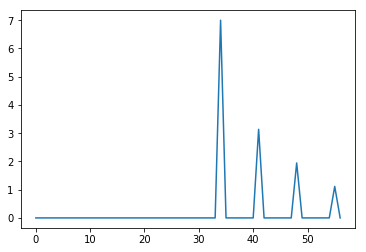

In [12]:
plt.plot(targetTotalT)
plt.show()

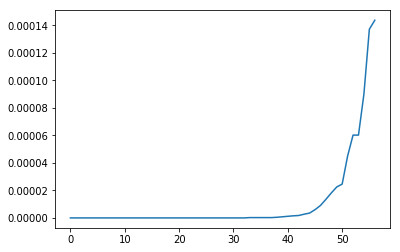

In [13]:
targetTotalP = targetTotalT

testTotal, targetTotalT = create_dataset([Loc2[st]],'Total_cases_data.csv',lb)

plt.plot(targetTotalT/totalPop[Loc2[st]])
plt.show()

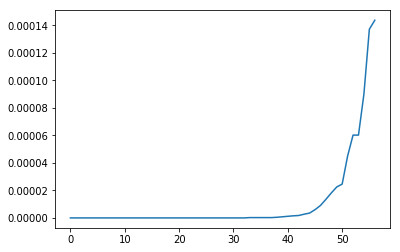

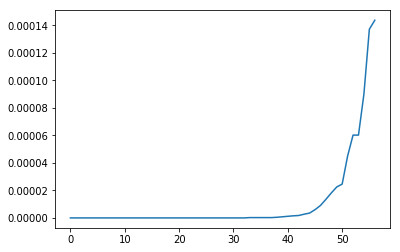

In [19]:
targetTotalS = targetTotalT/totalPop[Loc2[st]]
targetTotalP = np.power(targetTotalS,(1./ps))

plt.plot(targetTotalS)
plt.show()

plt.plot(targetTotalP)
plt.show()


In [24]:
sql = targetTotalP.shape[0]

meanTotal = []
targetTotalN = np.zeros((1,sql))

for ts in range(sql):
    testTotalT = testTotal[ts,:]
    testTotalS = testTotalT/totalPop[Loc2[st]]
    testTotalP = np.power(testTotalS,(1./ps))
    meanT = np.mean(testTotalP)
    if meanT > 0:
        targetTotalN[0,ts] = targetTotalP[ts]/meanT
    meanTotal.append(meanT)
    print(meanT)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.3456e-08
6.6912e-08
1.00368e-07
1.33824e-07
1.6728e-07
2.34192e-07
3.51288e-07
4.85112e-07
6.6912e-07
8.86584e-07
1.23787e-06
1.70626e-06
2.49247e-06
3.66343e-06
5.41987e-06
7.79525e-06
1.07561e-05
1.38842e-05
1.9806e-05
2.7551e-05
3.48612e-05
4.57845e-05
6.27802e-05


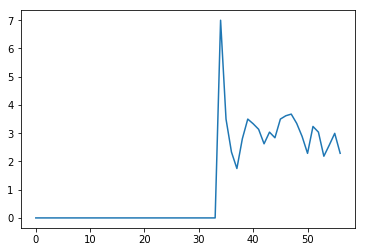

In [26]:
plt.plot(targetTotalN[0,:])
plt.show()